In [1]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import os;
from pybedtools import BedTool;
import subprocess;
import math;

In [8]:
CELLS = ["H1", "BJ", "K562", "GM12878", "HL_60"]
EXPERIMENT_FOLDER = "/mnt/stripe/dievsky/GSE65360"
MACS2_PS = ["0.001", "0.0001", "0.00001"]
# discover MACS2 peak files
macs2_peaks_paths = {}
for cell in CELLS:
    macs2_peaks_paths[cell] = {macs2_p: os.path.join(EXPERIMENT_FOLDER, "cleaned_cell_peaks", "macs2",
                                                     macs2_p, "{}_peaks.narrowPeak".format(cell))
                               for macs2_p in MACS2_PS}
#macs2_peaks_paths["total_pooled_data"] = {macs2_p: os.path.join(EXPERIMENT_FOLDER, "cleaned_all_peaks", "macs2",
#                                                   macs2_p, "pooled_peaks.narrowPeak")
#                                          for macs2_p in MACS2_PS}
# discover Span model files and BAMs
SPAN_BINS = ["100"]
span_model_paths = {}
bam_paths = {}
for cell in CELLS:
    #bam_paths[cell] = os.path.join(EXPERIMENT_FOLDER, "cleaned_cells", "{}.bam".format(cell))
    bam_paths[cell] = os.path.join("/mnt/stripe/dievsky/GSE65360/cleaned_cells_sorted", "{}.bam".format(cell))
    span_model_paths[cell] = {span_bin: os.path.join(EXPERIMENT_FOLDER, "cleaned_cell_peaks", "span", "{}_{}.span".format(cell, span_bin)) for span_bin in SPAN_BINS}
#bam_paths["total_pooled_data"] = os.path.join(EXPERIMENT_FOLDER, "cleaned_all", "pooled.bam")
#span_model_paths["total_pooled_data"] = {span_bin: os.path.join(EXPERIMENT_FOLDER, "cleaned_all_peaks", "span_keep_dup_0_old", "pooled_{}.span".format(span_bin)) for span_bin in SPAN_BINS}
SPAN_JAR = os.path.join(EXPERIMENT_FOLDER, "bin", "span-0.11.0.jar")
#CELLS.append('total_pooled_data')
# discover monocyte DHSs
dhs_paths = {cell: os.path.join(EXPERIMENT_FOLDER, "dhs", "{}.bed".format(cell)) for cell in CELLS}
CHROM_SIZES = os.path.join(EXPERIMENT_FOLDER, "hg19.chrom.sizes")

In [3]:
main_dataframe = pd.DataFrame(columns=['peak_caller', 'cell', 'p', 'bin', 'fdr', 'gap',
                                       'peak_count', 'dhs_by_peak', 'peak_by_dhs'])

In [4]:
# populate MACS2 entries
for cell in CELLS:
    dhs_path = dhs_paths[cell]
    dhs_file = BedTool(dhs_path)
    dhs_count = dhs_file.count()
    for macs2_p in MACS2_PS:
        print("Processing {} for p={}".format(cell, macs2_p))
        peaks_file = BedTool(macs2_peaks_paths[cell][macs2_p])
        peak_count = peaks_file.count()
        overlap = peaks_file.intersect(dhs_file, wa=True, u=True).count()
        peak_by_dhs = overlap * 100.0 / peak_count            
        overlap = dhs_file.intersect(peaks_file, wa=True, u=True).count()
        dhs_by_peak = overlap * 100.0 / dhs_count        
        main_dataframe.loc[len(main_dataframe)] = ('macs2', cell, float(macs2_p), math.nan, math.nan, math.nan,
                                                   peak_count, dhs_by_peak, peak_by_dhs)
main_dataframe.head()

Processing H1 for p=0.001
Processing H1 for p=0.0001
Processing H1 for p=0.00001
Processing BJ for p=0.001
Processing BJ for p=0.0001
Processing BJ for p=0.00001
Processing K562 for p=0.001
Processing K562 for p=0.0001
Processing K562 for p=0.00001
Processing GM12878 for p=0.001
Processing GM12878 for p=0.0001
Processing GM12878 for p=0.00001
Processing HL_60 for p=0.001
Processing HL_60 for p=0.0001
Processing HL_60 for p=0.00001


,peak_caller,cell,p,bin,fdr,gap,peak_count,dhs_by_peak,peak_by_dhs
0,macs2,H1,0.00100,NaN,NaN,NaN,100842,61.872169,35.592313
1,macs2,H1,0.00010,NaN,NaN,NaN,42569,45.217160,61.631704
2,macs2,H1,0.00001,NaN,NaN,NaN,42569,45.217160,61.631704
3,macs2,BJ,0.00100,NaN,NaN,NaN,74227,22.595474,87.166395
4,macs2,BJ,0.00010,NaN,NaN,NaN,74227,22.595474,87.166395


In [11]:
# populate Span entries -- takes 1+ hour
SPAN_FDRS = ["0.5", "0.1", "0.01", "1E-4", "1E-6", "1E-9", "1E-12"]
SPAN_GAPS = ["0", "2", "5"]
for cell in CELLS:
    bam_path = bam_paths[cell]
    dhs_path = dhs_paths[cell]
    dhs_file = BedTool(dhs_path)
    dhs_count = dhs_file.count()
    for span_bin in SPAN_BINS:    
        model_path = span_model_paths[cell][span_bin]
        work_dir = os.path.dirname(model_path)
        for span_fdr in SPAN_FDRS:
            for span_gap in SPAN_GAPS:
                peaks_path = "/tmp/span_peaks.bed"
                #command = ('java -jar {} analyze -t {} --chrom.sizes {} --model {} --bin {} '
                #           '--keep-dup --fragment 0 '
                #           '--fdr {} --gap {} --peaks {} --workdir {} --threads 8').format(
                #    SPAN_JAR, bam_path, CHROM_SIZES, model_path, span_bin, span_fdr, span_gap, peaks_path, work_dir)
                command = ('java -jar {} analyze --model {} --bin {} '
                           # '--fragment 0 --keep-dup '
                           '--fdr {} --gap {} --peaks {} --workdir {} --threads 8').format(
                    SPAN_JAR, model_path, span_bin, span_fdr, span_gap, peaks_path, work_dir)
                print('Running ' + command)
                subprocess.run(command, shell=True, check=True)
                peaks_file = BedTool(peaks_path)
                peak_count = peaks_file.count()
                print(peak_count)                
                overlap = peaks_file.intersect(dhs_file, wa=True, u=True).count()
                peak_by_dhs = overlap * 100.0 / peak_count if peak_count != 0 else math.nan
                overlap = dhs_file.intersect(peaks_file, wa=True, u=True).count()
                dhs_by_peak = overlap * 100.0 / dhs_count                
                main_dataframe.loc[len(main_dataframe)] = ('span', cell, math.nan, int(span_bin), float(span_fdr),
                                                           int(span_gap), peak_count, dhs_by_peak, peak_by_dhs)

Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/H1_100.span --bin 100 --fdr 0.5 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
235243
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/H1_100.span --bin 100 --fdr 0.5 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
230610
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/H1_100.span --bin 100 --fdr 0.5 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
219839
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/H1_100

82024
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/BJ_100.span --bin 100 --fdr 0.01 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
78565
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/BJ_100.span --bin 100 --fdr 1E-4 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
81503
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/BJ_100.span --bin 100 --fdr 1E-4 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
64665
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/

30473
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/K562_100.span --bin 100 --fdr 1E-9 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
26233
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/K562_100.span --bin 100 --fdr 1E-9 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
24707
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/K562_100.span --bin 100 --fdr 1E-12 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
21810
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peak

82925
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/HL_60_100.span --bin 100 --fdr 0.1 --gap 0 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
39183
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/HL_60_100.span --bin 100 --fdr 0.1 --gap 2 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
38858
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span/HL_60_100.span --bin 100 --fdr 0.1 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks/span --threads 8
38057
Running java -jar /mnt/stripe/dievsky/GSE65360/bin/span-0.11.0.jar analyze --model /mnt/stripe/dievsky/GSE65360/cleaned_cell_peaks

In [12]:
main_dataframe.describe()

,p,bin,fdr,gap,dhs_by_peak,peak_by_dhs
count,15.000000,105.0,1.050000e+02,105.000000,120.000000,120.000000
mean,0.000370,100.0,8.715729e-02,2.333333,28.707949,76.172711
std,0.000463,0.0,1.727570e-01,2.064660,18.995093,19.328398
min,0.000010,100.0,1.000000e-12,0.000000,3.824155,18.112335
25%,0.000010,100.0,1.000000e-09,0.000000,14.460515,69.510149
50%,0.000100,100.0,1.000000e-04,2.000000,22.932369,83.464106
75%,0.001000,100.0,1.000000e-01,5.000000,37.938417,89.683723
max,0.001000,100.0,5.000000e-01,5.000000,82.832068,97.593454


In [13]:
overlap_dataframe = main_dataframe[np.logical_not(np.isnan(main_dataframe['dhs_by_peak']))]
overlap_dataframe.describe()

,p,bin,fdr,gap,dhs_by_peak,peak_by_dhs
count,15.000000,105.0,1.050000e+02,105.000000,120.000000,120.000000
mean,0.000370,100.0,8.715729e-02,2.333333,28.707949,76.172711
std,0.000463,0.0,1.727570e-01,2.064660,18.995093,19.328398
min,0.000010,100.0,1.000000e-12,0.000000,3.824155,18.112335
25%,0.000010,100.0,1.000000e-09,0.000000,14.460515,69.510149
50%,0.000100,100.0,1.000000e-04,2.000000,22.932369,83.464106
75%,0.001000,100.0,1.000000e-01,5.000000,37.938417,89.683723
max,0.001000,100.0,5.000000e-01,5.000000,82.832068,97.593454


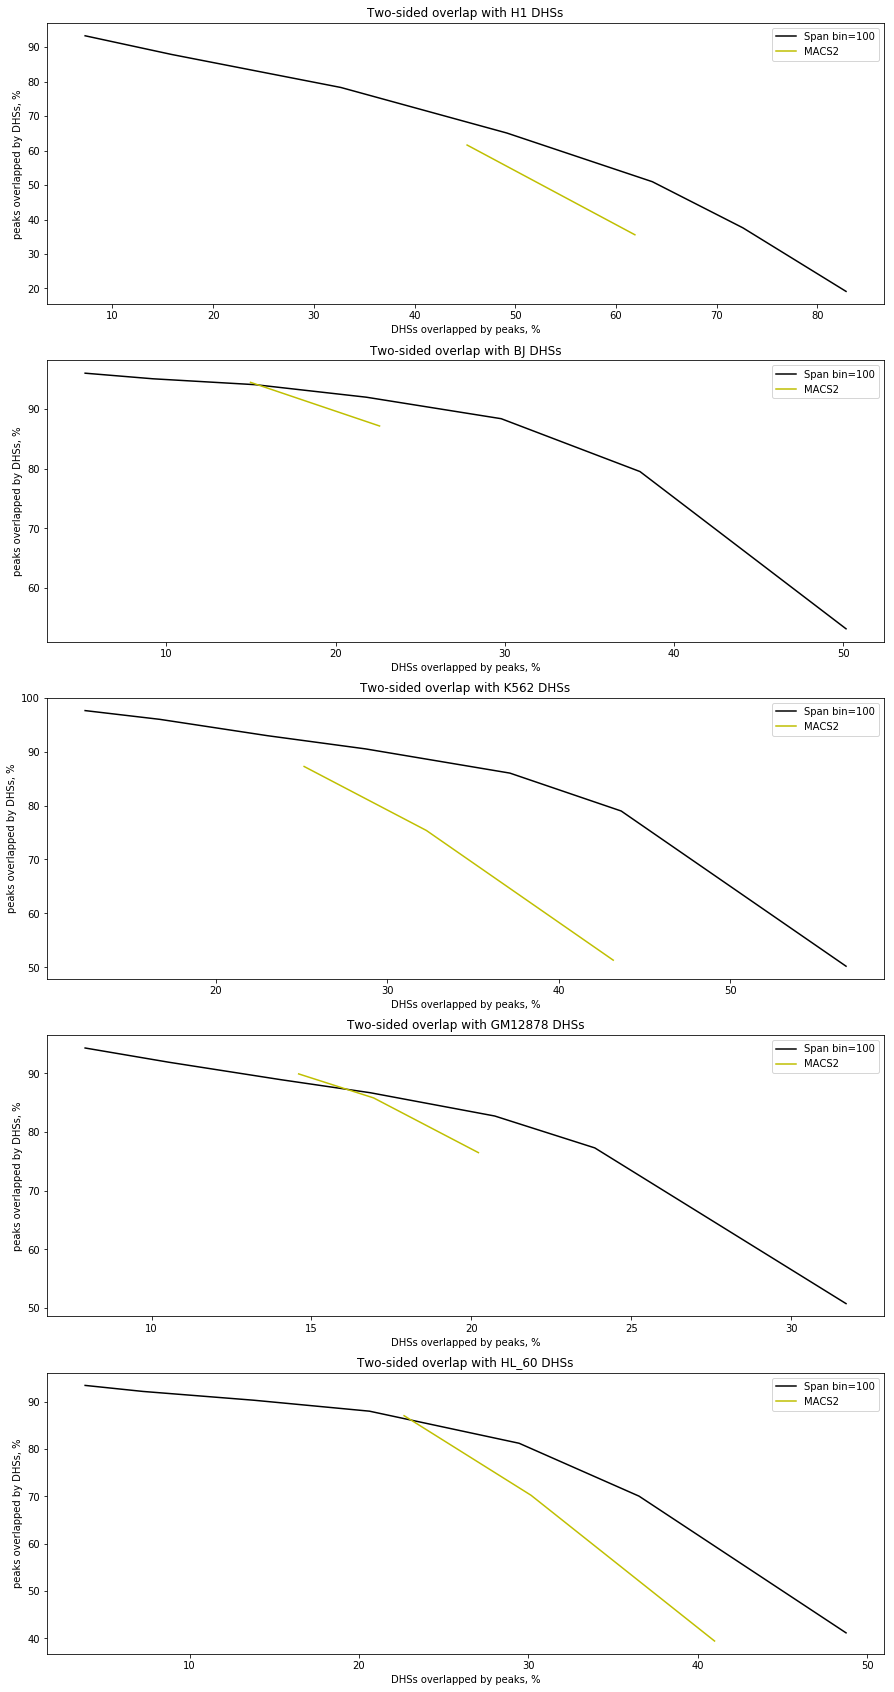

In [14]:
# Plot cell-wise DHSs overlap
# Only gap=5 is considered for Span
COLORS_FOR_BINS = {'50': 'b', '100': 'k', '200': 'c'}
fig, axes = plt.subplots(len(CELLS), 1, sharex=False, sharey=False, figsize=(15, 6 * len(CELLS)))
for ax, cell in zip(axes, CELLS):    
    for span_bin in SPAN_BINS:
        span_overlap_dataframe = overlap_dataframe[np.logical_and(
            np.logical_and(
                np.logical_and(
                    overlap_dataframe['peak_caller'] == 'span',
                    overlap_dataframe['gap'] == 5),
                overlap_dataframe['cell'] == cell),
            overlap_dataframe['bin'] == int(span_bin))]
        ax.plot(span_overlap_dataframe['dhs_by_peak'], span_overlap_dataframe['peak_by_dhs'], 
                 COLORS_FOR_BINS[span_bin], label='Span bin=' + span_bin)
    macs2_overlap_dataframe = overlap_dataframe[np.logical_and(
        overlap_dataframe['peak_caller'] == 'macs2',
        overlap_dataframe['cell'] == cell)]
    ax.plot(macs2_overlap_dataframe['dhs_by_peak'], macs2_overlap_dataframe['peak_by_dhs'], 'y', label='MACS2')
    ax.legend()
    ax.set_title("Two-sided overlap with {} DHSs".format(cell))
    ax.set_xlabel("DHSs overlapped by peaks, %")
    ax.set_ylabel("peaks overlapped by DHSs, %")    
plt.savefig('GSE65360_overlap_ROC.png', dpi=300)
plt.show()

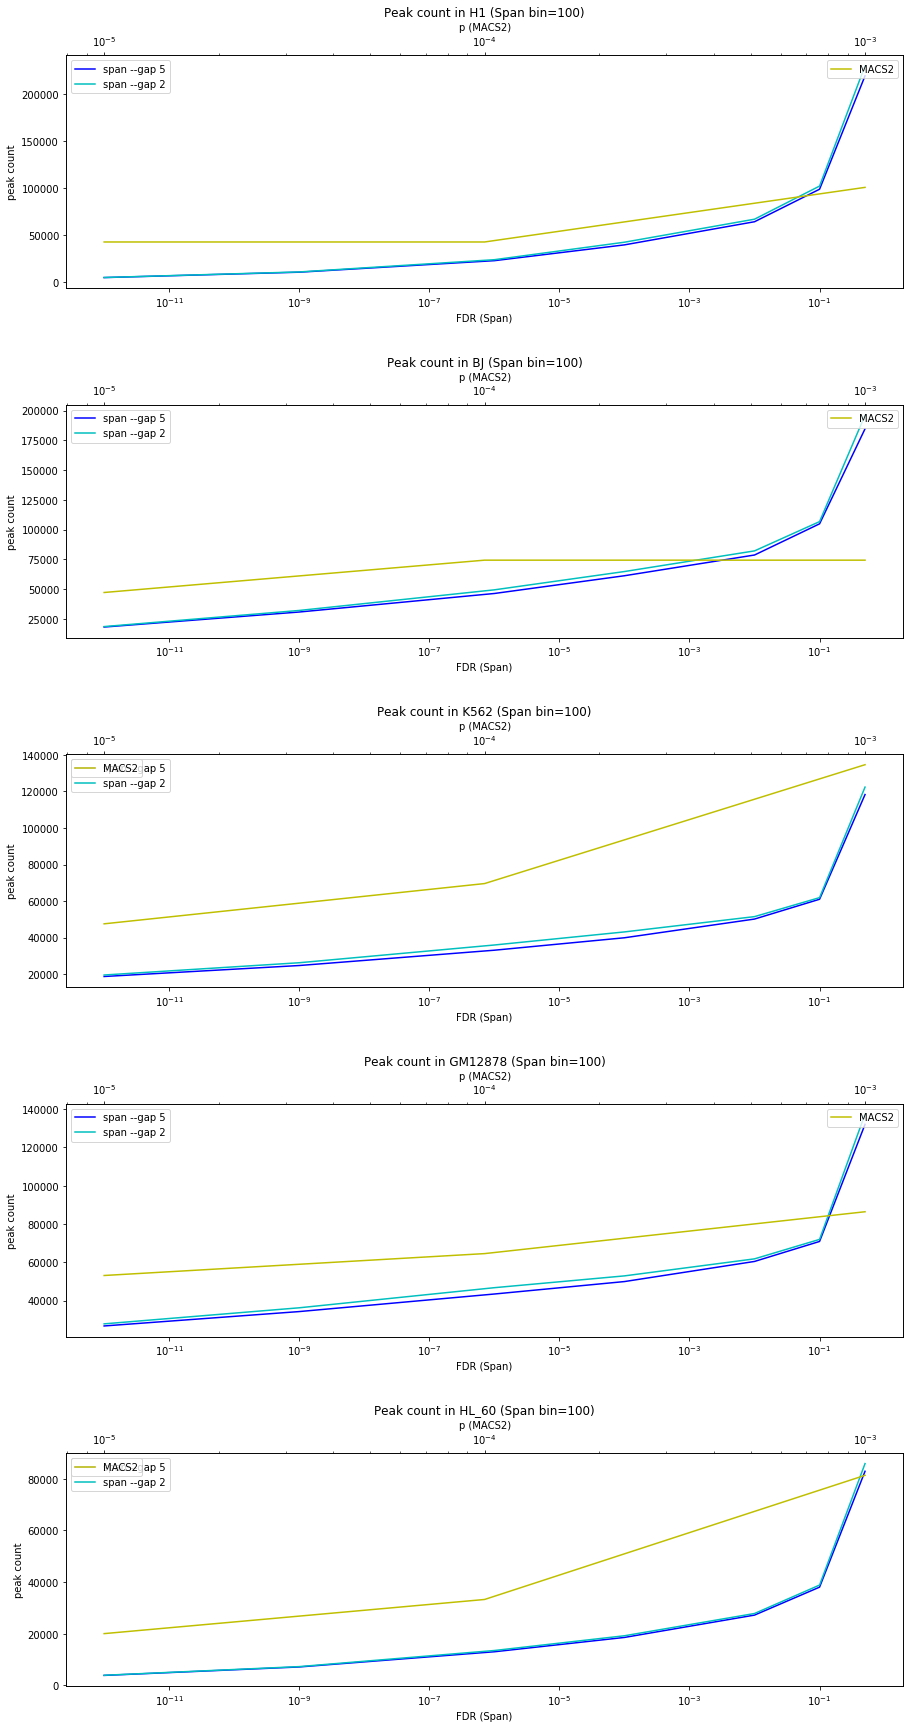

In [15]:
# Plot peak counts
fig, span_axes_matrix = plt.subplots(len(CELLS), len(SPAN_BINS), sharex=False, sharey=False, squeeze=False,
                                     figsize=(15, 6 * len(CELLS)))
for cell, span_axes_vector in zip(CELLS, span_axes_matrix):
    for span_bin, span_ax in zip(SPAN_BINS, span_axes_vector):
        peak_count_dataframe = main_dataframe[np.logical_and(main_dataframe['cell'] == cell,
                                                             np.logical_or(main_dataframe['peak_caller'] == 'macs2',
                                                                           main_dataframe['bin'] == int(span_bin)))]
        macs2_ax = span_ax.twiny()
        span_ax.set_xlabel('FDR (Span)')
        macs2_ax.set_xlabel('p (MACS2)')
        span_ax.set_xscale('log')
        macs2_ax.set_xscale('log')
        span_peak_count_5 = peak_count_dataframe[np.logical_and(peak_count_dataframe['peak_caller'] == 'span', peak_count_dataframe['gap'] == 5)]
        span_ax.plot(span_peak_count_5['fdr'], span_peak_count_5['peak_count'], 'b', label='span --gap 5')
        span_peak_count_2 = peak_count_dataframe[np.logical_and(peak_count_dataframe['peak_caller'] == 'span', peak_count_dataframe['gap'] == 2)]
        span_ax.plot(span_peak_count_2['fdr'], span_peak_count_2['peak_count'], 'c', label='span --gap 2')
        macs2_peak_count = peak_count_dataframe[peak_count_dataframe['peak_caller'] == 'macs2']
        macs2_ax.plot(macs2_peak_count['p'], macs2_peak_count['peak_count'], 'y', label='MACS2')
        span_ax.set_ylabel('peak count')
        span_ax.set_title('Peak count in ' + cell + ' (Span bin=' + span_bin + ')')        
        span_ax.legend()
        macs2_ax.legend()
fig.subplots_adjust(hspace=0.5)
fig.savefig("GSE65360_peak_count.png", dpi=300)
plt.show()